In [134]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pdb

This NB contains the analysis of the merged .xlsx, only the trades that are in RSI oversold area for all currencies

Parsing .xlsx

In [135]:
DF = pd.read_excel("/Users/ernesto/Google Drive/WORKING_FX/TRADE_BOT/09_04_2020/allpairs.merged.xlsx")

# Analysis of trades

## Transforming
We will transform the 2 outcome labels to digits

In [136]:
transl_dict={ 
        'S':1,
        'F':0,
        'success' : 1,
        'failure' : 0,
        True:1, 
        False:0
    }
def digit_binary(x,transl_dict,name):
    '''
    This function will replace the values in categorical
    binary variables by 1 and 0
    
    Parameters
    ----------
    transl_dict: dict
                 Keys will be the old categorical names and Values
                 will be 1 and 0. For example:
                 transl_dict={ 
                            'S':1,
                            'F':0, 
                            True:1, 
                            False:0
                            }
    name: str
          Name of the column to modify
        
    Returns
    -------
    The new label for the categorical variable
    '''
    return transl_dict[x[name]]

DF['outcome']=DF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='outcome')

# Selecting the trades in overlsold area

Selection of trades with a RSI >=70 or RSI <=30

In [188]:
subDF=DF.loc[(DF['max_min_rsi']>=70)|(DF['max_min_rsi'] <=30)]

In [189]:
subDF.shape

(550, 22)

The frequency for each outcome category

In [176]:
print(pd.crosstab(subDF['outcome'], columns="freq").apply(lambda r: r/r.sum(), axis=0))

col_0        freq
outcome          
0        0.617117
1        0.382883


## last time
This datetime variable represents the last time the price was over/below the entry price level. The first to do is to create a new datetime variable representing the difference (in days) between the entry datetime (start column) and the last time datetime.¶

First thing we need to do is to convert the variables `start` and `lasttime` to Datetime class

In [177]:
subDF['lasttime']= pd.to_datetime(subDF['lasttime'])
subDF['start'] = pd.to_datetime(subDF['start'])

/Users/ernesto/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ernesto/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [178]:
subDF['diff_lasttime']=(subDF['start']-subDF['lasttime'])
subDF['diff_lasttime']=subDF['diff_lasttime'].apply(lambda x: x.days)

/Users/ernesto/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ernesto/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now, let's examine the distribution of this newly created diff variable in the 2 outcome categories

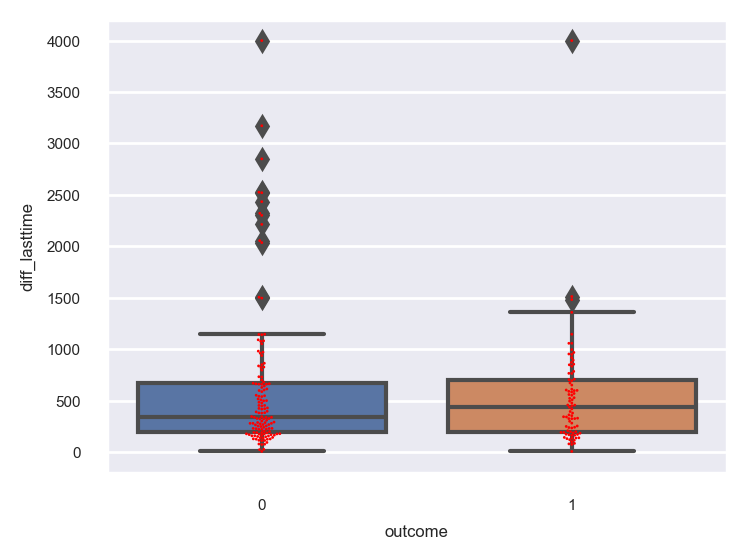

In [179]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

ax = sns.boxplot(x="outcome", y="diff_lasttime", data=subDF, ax=ax)

sns.swarmplot(x="outcome", y="diff_lasttime", data=subDF, color="red", size=1, ax=ax)

* Mean for each category

In [180]:
subDF.groupby("outcome").agg({'diff_lasttime': 'mean'})

,diff_lasttime
outcome,
0,603.547445
1,531.341176


* Median for each category

In [181]:
subDF.groupby("outcome").agg({'diff_lasttime': 'median'})

,diff_lasttime
outcome,
0,345
1,435


* Binning data
Let's bin the data into a certain number of categories

In [182]:
max_v=max(subDF['diff_lasttime'])

custom_bins_array = np.arange(0, max_v, 150)

subDF['diff_cat']=pd.cut(subDF['diff_lasttime'], np.around(custom_bins_array))

/Users/ernesto/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

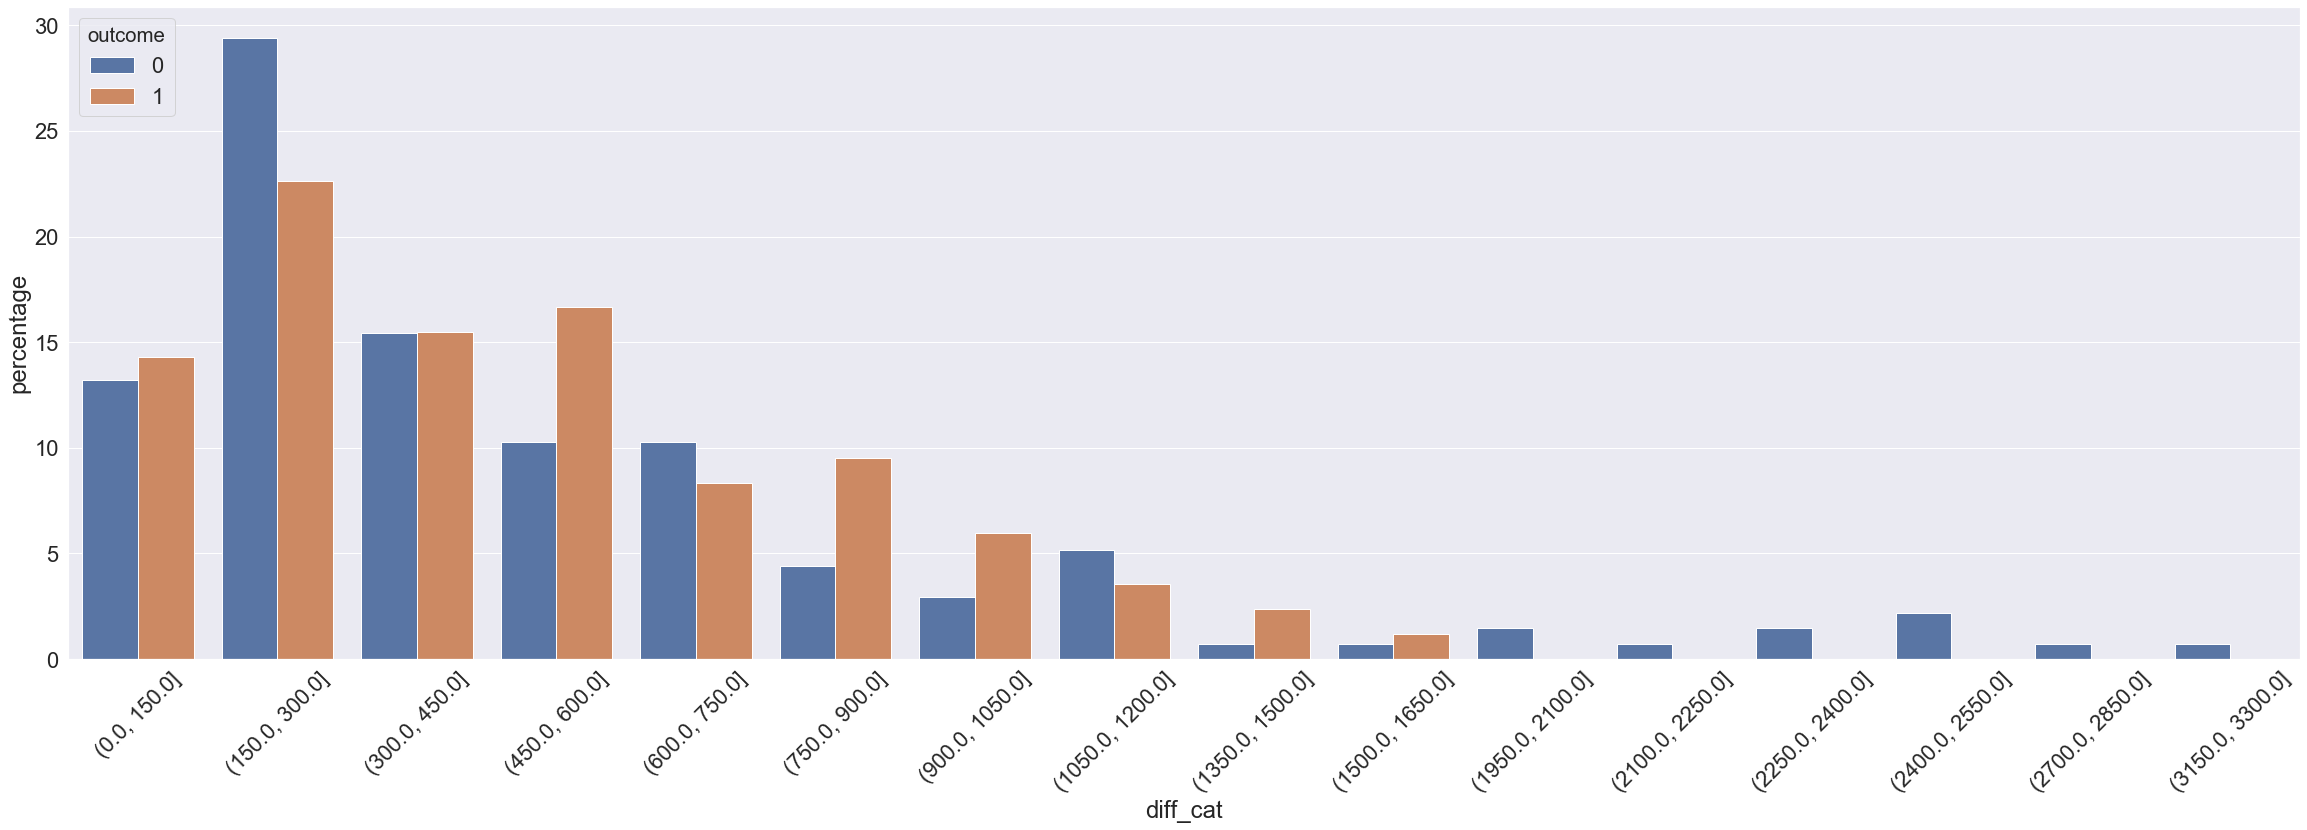

In [183]:
DF_counts = (subDF.groupby(['outcome'])['diff_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('diff_cat'))

sns.set(rc={'figure.figsize':(40,12)},font_scale=2)

p = sns.barplot(x="diff_cat", y="percentage",
                hue='outcome', data=DF_counts)

plt.xticks(rotation=45)

Let's calculate the frequency for each outcome category for trades having a diff_lasttime value of at least 300

In [186]:
subDF_gt300=subDF.loc[(subDF['diff_lasttime']<=300)]

In [187]:
print(pd.crosstab(subDF_gt300['outcome'], columns="freq").apply(lambda r: r/r.sum(), axis=0))

col_0       freq
outcome         
0        0.54023
1        0.45977


# Pivots
This quantitative discrete variable is used for representing the number of times the price has tested this level. 

In [149]:
import ast
import pdb

def get_no_pivots(x):
    pivots = ast.literal_eval(x['pivots'])
    return len(pivots)

subDF['no_pivots']=subDF.apply(get_no_pivots,axis=1)

/Users/ernesto/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's start comparing the distribution of this variable for the different categories of the outcome variable.§m

* Mean for each category

In [150]:
subDF.groupby("outcome").agg({'no_pivots': 'mean'})

,no_pivots
outcome,
0,4.911765
1,4.647059


* Median for each category

In [151]:
subDF.groupby("outcome").agg({'no_pivots': 'median'})

,no_pivots
outcome,
0,4
1,4


* Binning data
Let's bin the data into a certain number of categories

In [152]:
max_v=max(subDF['no_pivots'])

custom_bins_array = np.arange(0, max_v, 1)

subDF['bounces peak_cat']=pd.cut(subDF['no_pivots'], np.around(custom_bins_array))

/Users/ernesto/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


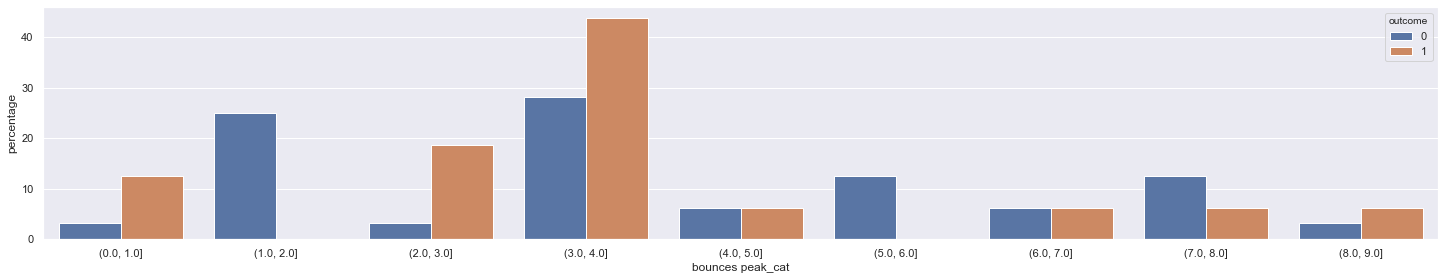

In [153]:
subDF_counts = (subDF.groupby(['outcome'])['bounces peak_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('bounces peak_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="bounces peak_cat", y="percentage", hue='outcome', data=subDF_counts)

# pivots_lasttime
This quantitative discrete variable is used for representing the number of times the price has tested this level since last_time. Let's start comparing the distribution of this variable for the different categories of the outcome variable.¶

In [154]:
import ast
import pdb

def get_no_pivots_lasttime(x):
    pivots = ast.literal_eval(x['pivots_lasttime'])
    return len(pivots)

subDF['no_pivots_lasttime']=subDF.apply(get_no_pivots_lasttime,axis=1)

/Users/ernesto/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


* Mean for each category

In [155]:
subDF.groupby("outcome").agg({'no_pivots_lasttime': 'mean'})

,no_pivots_lasttime
outcome,
0,1.205882
1,1.411765


* Median for each category

In [156]:
subDF.groupby("outcome").agg({'no_pivots_lasttime': 'median'})

,no_pivots_lasttime
outcome,
0,1
1,1


* Binning data
Let's bin the data into a certain number of categories. `np.arange(0,max_v,1)` where 1 controls the width of each bin

In [157]:
max_v=max(subDF['no_pivots_lasttime'])

custom_bins_array = np.arange(0, max_v, 1)

subDF['bounces peak_cat']=pd.cut(subDF['no_pivots_lasttime'], np.around(custom_bins_array))

/Users/ernesto/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


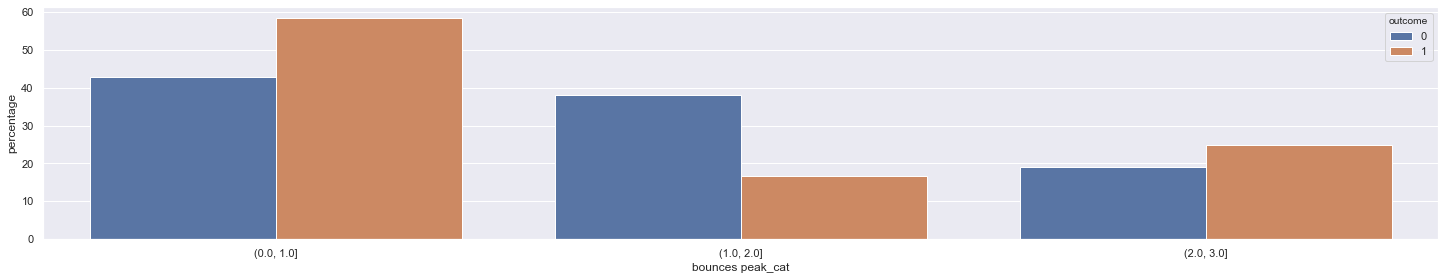

In [158]:
subDF_counts = (subDF.groupby(['outcome'])['bounces peak_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('bounces peak_cat'))

sns.set(rc={'figure.figsize':(25,4.27)})

p = sns.barplot(x="bounces peak_cat", y="percentage", hue='outcome', data=subDF_counts)

## total score

* Mean for each category

In [159]:
subDF.groupby("outcome").agg({'total_score': 'mean'})

,total_score
outcome,
0,3810.314706
1,4120.676471


* Median for each category

In [160]:
subDF.groupby("outcome").agg({'total_score': 'median'})

,total_score
outcome,
0,3869.2
1,3853.3


Now, let's examine the distribution of this newly created diff variable in the 2 outcome categories

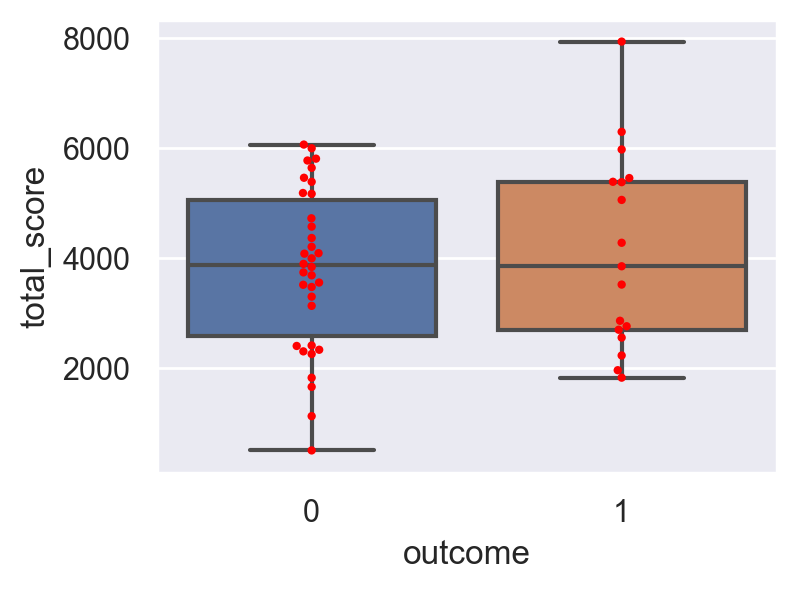

In [161]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

ax = sns.boxplot(x="outcome", y="total_score", data=subDF, ax=ax)

sns.swarmplot(x="outcome", y="total_score", data=subDF, color="red", size=3, ax=ax)

## score_lasttime

* Mean for each category

In [162]:
subDF.groupby("outcome").agg({'score_lasttime': 'mean'})

,score_lasttime
outcome,
0,1163.479412
1,1556.505882


* Median for each category

In [163]:
subDF.groupby("outcome").agg({'score_lasttime': 'median'})

,score_lasttime
outcome,
0,870.3
1,1371.1


Now, let's examine the distribution of this newly created diff variable in the 2 outcome categories

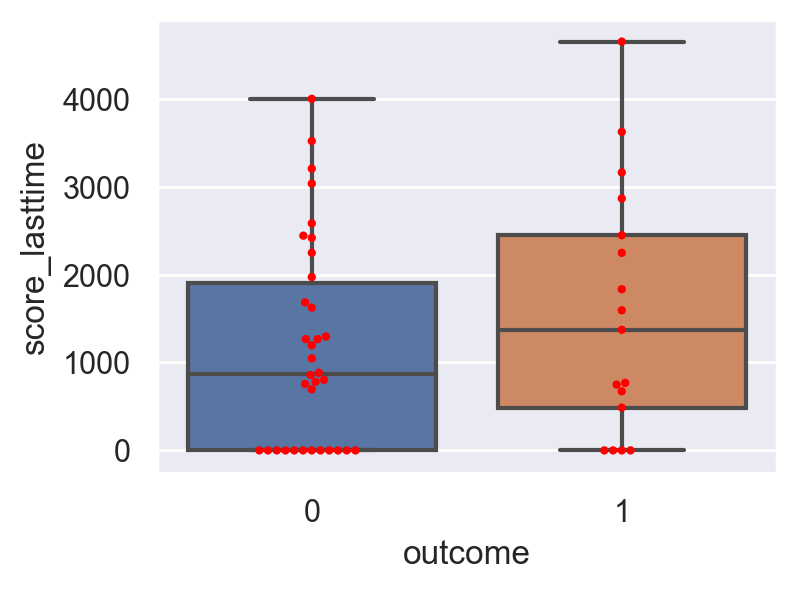

In [164]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

ax = sns.boxplot(x="outcome", y="score_lasttime", data=subDF, ax=ax)

sns.swarmplot(x="outcome", y="score_lasttime", data=subDF, color="red", size=3, ax=ax)

## score_pivot

Mean score per pivot

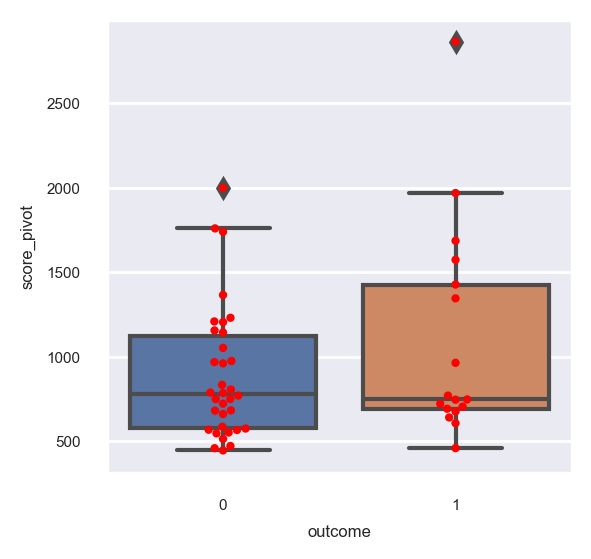

In [165]:
sns.set(font_scale=0.5)


fig, ax = plt.subplots(figsize=(3, 3), dpi=200)


sns.boxplot(x="outcome", y="score_pivot", data=subDF, ax=ax)

sns.swarmplot(x="outcome", y="score_pivot", data=subDF, color="red", size=3, ax=ax)

* Mean for each category

In [166]:
subDF.groupby("outcome").agg({'score_pivot': 'mean'})

,score_pivot
outcome,
0,889.772989
1,1093.137753


* Median for each category

In [167]:
subDF.groupby("outcome").agg({'score_pivot': 'median'})

,score_pivot
outcome,
0,776.6625
1,746.4875


## score_pivot_lasttime

Mean score per pivot after lasttime

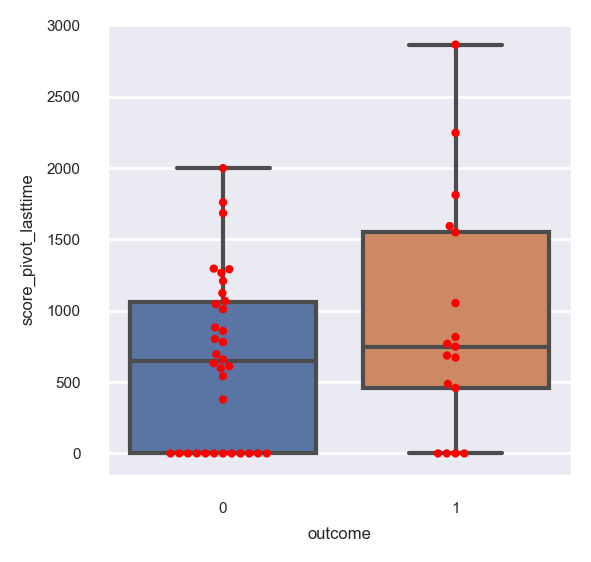

In [168]:
sns.set(font_scale=0.5)


fig, ax = plt.subplots(figsize=(3, 3), dpi=200)


sns.boxplot(x="outcome", y="score_pivot_lasttime", data=subDF, ax=ax)

sns.swarmplot(x="outcome", y="score_pivot_lasttime", data=subDF, color="red", size=3, ax=ax)

* Mean for each category

In [169]:
subDF.groupby("outcome").agg({'score_pivot_lasttime': 'mean'})

,score_pivot_lasttime
outcome,
0,652.460539
1,926.613235


* Median for each category

In [170]:
subDF.groupby("outcome").agg({'score_pivot_lasttime': 'median'})

,score_pivot_lasttime
outcome,
0,644.8
1,748.3


* Binning data
Let's bin the data into a certain number of categories

In [171]:
max_v=max(subDF['score_pivot_lasttime'])

custom_bins_array = np.arange(0, max_v, 150)

subDF['sc_ltime_cat']=pd.cut(subDF['score_pivot_lasttime'], np.around(custom_bins_array))

/Users/ernesto/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 <a list of 22 Text xticklabel objects>)

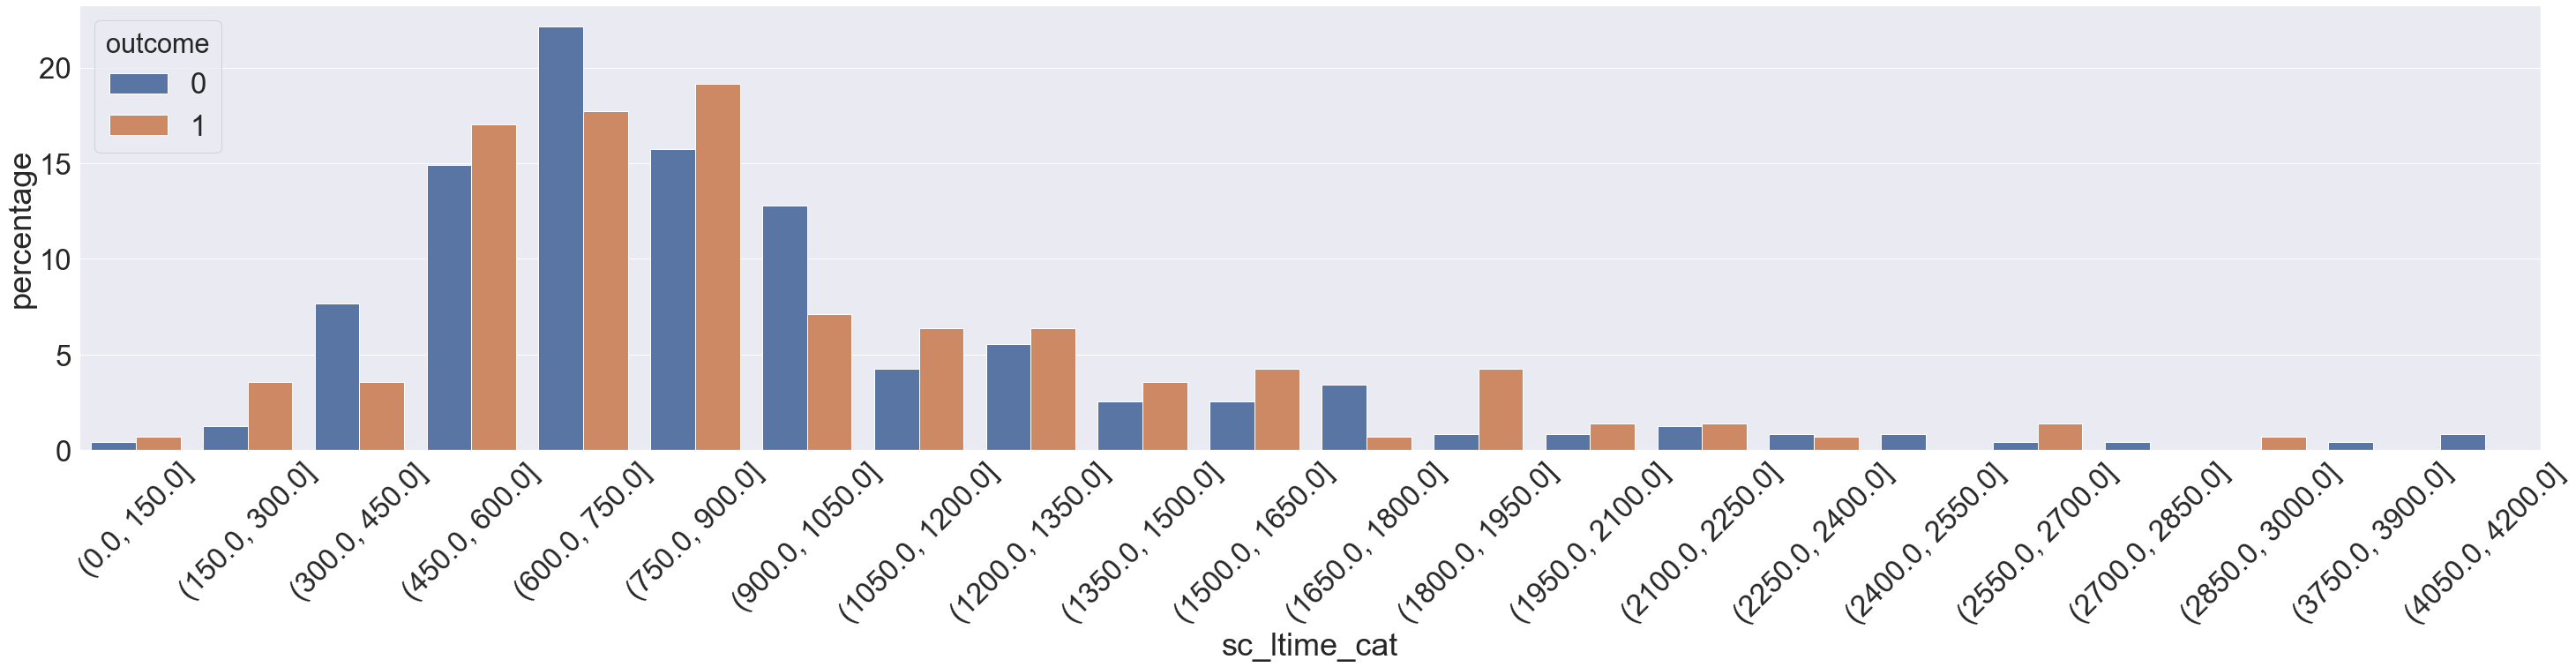

In [92]:
subDF_counts = (subDF.groupby(['outcome'])['sc_ltime_cat']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('sc_ltime_cat'))

sns.set(rc={'figure.figsize':(50,9.27)}, font_scale=3)

p = sns.barplot(x="sc_ltime_cat", y="percentage", hue='outcome', data=subDF_counts)

plt.xticks(rotation=45)